In [1]:
#importing the libraries
import os
import numpy as np
import pandas as pd

import csv
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import tree, ensemble, metrics, cross_validation, externals,linear_model
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 40)

%matplotlib inline
plt.style.use('ggplot')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
%install_ext https://raw.github.com/cjdrake/ipython-magic/master/gvmagic.py

/Users/dkhandelwal/anaconda/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed gvmagic.py. To use it, type:
  %load_ext gvmagic


## Function Definitions

## Creating a Data Frame

In [3]:
df = pd.read_csv('Kaggle_YourCabs_training.csv')
df1 = pd.read_csv('Kaggle_YourCabs_training.csv')

In [4]:
df.columns


Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error'],
      dtype='object')

## Quick Analysis for the dependant variable

In [5]:
df['Car_Cancellation'].value_counts()


0    40299
1     3132
Name: Car_Cancellation, dtype: int64

# Vehicle Model id and its transformation:
## Approach- Create a new categorical feature 'vehicle_type' that contains the popularity of the vehicle type_id, 1 being the most popular

In [6]:

df.vehicle_model_id.unique()

array([28, 12, 65, 24, 87, 54, 85, 17, 23, 36, 72, 30, 43, 86, 76,  1, 69,
       14, 89, 10, 13, 64, 90, 75, 70, 91, 39])

In [7]:
df.vehicle_model_id.value_counts()

12    31859
85     2407
89     2391
65     1912
28     1702
24     1494
87      565
90      312
23      297
86      123
      ...  
13        7
43        2
72        2
1         2
75        1
76        1
39        1
70        1
69        1
14        1
Name: vehicle_model_id, dtype: int64

In [8]:
df.vehicle_model_id.isnull().sum()

0

# Transformation

Note-vehicle_model_id is the model type

In [9]:
print range(len(df.vehicle_model_id.value_counts()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


### The code below creates a Dataframe with model_id and vehicle_counts 

In [10]:
p =  df.vehicle_model_id.value_counts()
print p.index
print p.values
vehicle_cat_df = pd.DataFrame({ 'model_id':p.index , 'vehicle_count':p.values })
vehicle_cat_df.head(20)

Int64Index([12, 85, 89, 65, 28, 24, 87, 90, 23, 86, 10, 64, 54, 17, 91, 30, 36,
            13, 43, 72,  1, 75, 76, 39, 70, 69, 14],
           dtype='int64')
[31859  2407  2391  1912  1702  1494   565   312   297   123   104    85
    73    40    25    14     9     7     2     2     2     1     1     1
     1     1     1]


,model_id,vehicle_count
0,12,31859
1,85,2407
2,89,2391
3,65,1912
4,28,1702
5,24,1494
6,87,565
7,90,312
8,23,297
9,86,123


In [11]:
#This function categories the vehicle_types into categories, based on the %ages of popular vehicles
def categorize_vehicle():
    #Cat_1 is the most popular vehicle
    cat_1 = vehicle_cat_df.vehicle_count.max()
    cat_2 = round(vehicle_cat_df.vehicle_count.quantile(.75))
    cat_3 = round(vehicle_cat_df.vehicle_count.quantile(.5))
    cat_4 = round(vehicle_cat_df.vehicle_count.quantile(.25))
    
    # Level 2 is the %age of vehicle between 75% and max
    level_2 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_1) & (vehicle_cat_df.vehicle_count >=cat_2)]
    count = len(level_2)
    for i in range(len(level_2)):
        print "The value of model id being processeed is %r.." %level_2.model_id[i+1]
        df.loc[df['vehicle_model_id'] == level_2.model_id[i+1] ,'vehicle_type'] = 2
    print df.vehicle_type.value_counts()
    
    # 75 to 50%
    level_3 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_2) & (vehicle_cat_df.vehicle_count >=cat_3)]
    j = count+1
    for i in range(1,len(level_3)):
        print "The value of model id being processeed is %r.." %level_3.model_id[j]
        
        df.loc[df['vehicle_model_id'] == level_3.model_id[j] ,'vehicle_type'] = 3
        j+=1
    print df.vehicle_type.value_counts()
    
    # 50 to 25%
    level_4 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_3) & (vehicle_cat_df.vehicle_count >=cat_4)]
    k = j+1
    for i in range(1,(len(level_4))):
        print "The value of model id being processeed is %r.." %level_4.model_id[k]
        df.loc[df['vehicle_model_id'] == level_4.model_id[k] ,'vehicle_type'] = 4
        k+=1
    print df.vehicle_type.value_counts()
    
    # 25 and below
    l = k+1
    level_5 = vehicle_cat_df[['model_id']][(vehicle_cat_df.vehicle_count < cat_4) & (vehicle_cat_df.vehicle_count > 0)]
    for i in range(1,(len(level_5))):
        print "The value of model id being processeed is %r.." %level_5.model_id[l]
        df.loc[df['vehicle_model_id'] == level_5.model_id[l] ,'vehicle_type'] = 5
        l+=1
    print df.vehicle_type.value_counts()

        

### The code below creates the range on vehicle_categories and call the function categorization

In [12]:


df['vehicle_type'] = '1'

# Categorizing levels
categorize_vehicle()





The value of model id being processeed is 85..
The value of model id being processeed is 89..
The value of model id being processeed is 65..
The value of model id being processeed is 28..
The value of model id being processeed is 24..
The value of model id being processeed is 87..
1    32960
2    10471
Name: vehicle_type, dtype: int64
The value of model id being processeed is 90..
The value of model id being processeed is 23..
The value of model id being processeed is 86..
The value of model id being processeed is 10..
The value of model id being processeed is 64..
The value of model id being processeed is 54..
1    31966
2    10471
3      994
Name: vehicle_type, dtype: int64
The value of model id being processeed is 91..
The value of model id being processeed is 30..
The value of model id being processeed is 36..
The value of model id being processeed is 13..
The value of model id being processeed is 43..
The value of model id being processeed is 72..
1    31907
2    10471
3      994


Note:- 31K (of 43K~72%) of all the vehciles rented are of Model_id=12


# Exploring the feature from_city_id:
This represents unique identifier of city


In [13]:
df.from_city_id.isnull().sum()

27086

In [14]:
df[df.Car_Cancellation==1][['from_city_id']].isnull().sum()

from_city_id    1441
dtype: int64

In [15]:
df[['from_city_id','Car_Cancellation']].corr()

,from_city_id,Car_Cancellation
from_city_id,1.000000,0.024755
Car_Cancellation,0.024755,1.000000


## Analysis and Transformation on User_id
The idea is to create a categorical feature that captures the booking/weights of the time a user has made the booking
if a user is a returning user user_id is 1 otherwise 0

In [16]:
len(df.user_id.unique())


22267

In [17]:
(df.user_id.value_counts() > 1).sum()

6332

In [18]:
df['frequent_user_1']=0


#### 22267 unique users and out of which 6332 have reused the service 

#### Creating a new feature frequent_user and initializing it to 0

In [19]:
df['frequent_user'] = 0

In [20]:
# This is a series with TRUE for each of the user id that has booked multiple times
is_frequent = df.user_id.value_counts()>1
#p =  df.vehicle_model_id.value_counts()
print is_frequent.index
print is_frequent.values


Int64Index([29648,   868, 27458, 32527, 34972, 33002, 29275, 32023, 30290,
            38538,
            ...
            42119, 29853, 44198, 27806, 25759, 38049, 36002, 48292, 46245,
             8196],
           dtype='int64', length=22267)
[ True  True  True ..., False False False]


In [21]:
#The function below takes the user_id as input and checks the value against the index of the series, returns 1 for True and 0 for False
def check_frequent(user_id):
    if is_frequent.ix[user_id]==True:
        return '1'
    else:
        return '0'

In [22]:
#Calling function on the second column(user_id) for each of the rows
#df.head()
df['frequent_user']= df.iloc[:, 1].apply(check_frequent)

In [23]:
#df['frequent_user']=df['frequent_user_1']
df.frequent_user.value_counts()

1    27496
0    15935
Name: frequent_user, dtype: int64

In [24]:
df.frequent_user.isnull().sum()

0

## from_Areaid and to_area_id

In [25]:
len(df.from_area_id.unique())
#599 unique values for Area id 

599

In [26]:
df.from_area_id.value_counts()

393.0     3858
571.0     1631
293.0     1052
585.0      911
1010.0     768
142.0      727
83.0       719
1384.0     628
1096.0     542
58.0       466
          ... 
1277.0       1
1380.0       1
802.0        1
1252.0       1
235.0        1
369.0        1
1127.0       1
1125.0       1
1253.0       1
1403.0       1
Name: from_area_id, dtype: int64

In [27]:
df.from_area_id.value_counts().mean()

72.4799331103679

In [28]:
(df.from_area_id.value_counts()<72).sum()

444

In [29]:
(df.from_area_id.value_counts()>72).sum()

154

#### 72 is the mean value of the no of booking from a specific area , on a closer look it seems that out of 599 areas served by the company , a majority of the areas 444, have less than the avg no of booking per area and around 154 areas have higher than the avg no of booking per area

In [30]:
len(df.from_area_id.unique())

599

In [31]:
len(df.to_area_id.unique())

569

In [32]:
df.from_area_id.value_counts()>df.from_area_id.value_counts().mean()

393.0      True
571.0      True
293.0      True
585.0      True
1010.0     True
142.0      True
83.0       True
1384.0     True
1096.0     True
58.0       True
          ...  
1277.0    False
1380.0    False
802.0     False
1252.0    False
235.0     False
369.0     False
1127.0    False
1125.0    False
1253.0    False
1403.0    False
Name: from_area_id, dtype: bool

In [33]:
# the function below will check the from_booking location is greater than the Mean value of the most frequent booking
# If yes , populate the popular_pickup to 1 else populate it to 0

df['Popular_Pickup']='0'
is_popular_pickup = df.from_area_id.value_counts()>df.from_area_id.value_counts().mean()

def check_popular(area_id):
    if is_popular_pickup.ix[area_id].any()==True:
        return '1'
    else:
        return '0'

    
    
def check_popular_Drop(area_id):
    if is_popular_Drop.ix[area_id].any()==True:
        return '1'
    else:
        return '0'

In [34]:

df['Popular_Pickup'] = df.iloc[:, 5].apply(check_popular)


In [35]:
df.Popular_Pickup.value_counts()

1    34259
0     9172
Name: Popular_Pickup, dtype: int64

In [36]:
df.to_area_id.value_counts()

393.0     8777
585.0     2339
1384.0    1237
571.0      664
293.0      555
1010.0     480
83.0       365
168.0      338
1371.0     332
452.0      330
          ... 
201.0        1
1196.0       1
1201.0       1
1207.0       1
1233.0       1
174.0        1
1252.0       1
1266.0       1
1271.0       1
1403.0       1
Name: to_area_id, dtype: int64

In [37]:
df.to_area_id.value_counts().mean()

60.375

In [38]:
(df.to_area_id.value_counts()>60).sum()

104

### #### 60 is the mean value of the no of booking from a specific area , on a closer look it seems that out of 569 areas served by the company , a majority of the areas 462, have less than the avg no of booking per area and around 104 areas have higher than the avg no of booking per area

In [39]:
df['Popular_Drop']='0'
is_popular_Drop = df.to_area_id.value_counts()>df.to_area_id.value_counts().mean()


In [40]:
df['Popular_Drop'] = df.iloc[:, 6].apply(check_popular_Drop)


In [41]:
df.Popular_Drop.value_counts()

1    26994
0    16437
Name: Popular_Drop, dtype: int64

In [42]:
df.Popular_Drop.isnull().sum()

0

## to_city_id - unique identifier of city (only for intercity)


In [43]:
df.to_city_id.isnull().sum()

41843

In [44]:
#### 41 K out of 43 K have Null values- Definitely Drop it

## getting rid of package_id which has ~35K null values,vehicle_model_id,to_city_id

## DATE Fields-from_date- Timestamp of the requested trip start

In [45]:
len(df.from_date.unique())

20377

In [46]:
df.from_date

0           1/1/13 2:00
1           1/1/13 9:00
2           1/1/13 3:30
3           1/1/13 5:45
4           1/1/13 9:00
5          1/1/13 22:30
6           1/1/13 9:45
7          1/1/13 11:00
8          1/1/13 16:00
9          1/1/13 11:00
              ...      
43421     11/25/13 9:45
43422    11/24/13 21:15
43423    11/24/13 16:00
43424    11/24/13 15:15
43425     11/25/13 0:00
43426    11/24/13 18:00
43427     11/26/13 1:00
43428    11/24/13 18:30
43429    11/24/13 16:00
43430     11/25/13 5:00
Name: from_date, dtype: object

In [47]:
#df.DateTime[-1]
type(df.from_date[1])

str

#### Transforming a string value to Date time on from_Date and To_Date

In [48]:
df.from_date = pd.to_datetime(df.from_date)

In [49]:
df.from_date.apply(lambda date: date.month)

0         1
1         1
2         1
3         1
4         1
5         1
6         1
7         1
8         1
9         1
         ..
43421    11
43422    11
43423    11
43424    11
43425    11
43426    11
43427    11
43428    11
43429    11
43430    11
Name: from_date, dtype: int64

In [50]:
type(df.from_date[1])

pandas.tslib.Timestamp

In [51]:
def get_month(x):
    return x.month





df['Req_start_Month'] = df['from_date'].apply(get_month)

In [52]:
df.Req_start_Month.value_counts().isnull()

8     False
7     False
10    False
9     False
6     False
5     False
11    False
4     False
2     False
1     False
3     False
12    False
Name: Req_start_Month, dtype: bool

In [53]:
df.to_date = pd.to_datetime(df.to_date)
df['Req_end_Month'] = df['to_date'].apply(get_month)

In [54]:
df.to_date

0                                 NaT
1                                 NaT
2                                 NaT
3                                 NaT
4                                 NaT
5                                 NaT
6       1970-01-01 00:00:00.000041275
7                                 NaT
8                                 NaT
9                                 NaT
                     ...             
43421   1970-01-01 00:00:00.000041603
43422   1970-01-01 00:00:00.000041602
43423   1970-01-01 00:00:00.000041602
43424   1970-01-01 00:00:00.000041603
43425   1970-01-01 00:00:00.000041603
43426   1970-01-01 00:00:00.000041602
43427   1970-01-01 00:00:00.000041604
43428   1970-01-01 00:00:00.000041602
43429   1970-01-01 00:00:00.000041602
43430   1970-01-01 00:00:00.000041603
Name: to_date, dtype: datetime64[ns]

### Note- The to_date seems to have a junk value as it has a default 1970 date- should be ignored

In [55]:
df.booking_created

0           1/1/13 1:39
1           1/1/13 2:25
2           1/1/13 3:08
3           1/1/13 4:39
4           1/1/13 7:53
5           1/1/13 8:01
6           1/1/13 9:21
7           1/1/13 9:39
8           1/1/13 9:44
9           1/1/13 9:49
              ...      
43421    11/24/13 14:10
43422    11/24/13 14:12
43423    11/24/13 14:15
43424    11/24/13 14:23
43425    11/24/13 14:24
43426    11/24/13 14:25
43427    11/24/13 14:30
43428    11/24/13 14:35
43429    11/24/13 14:43
43430    11/24/13 14:50
Name: booking_created, dtype: object

In [56]:
df.booking_created = pd.to_datetime(df.booking_created)

df['Creation_Month'] = df['booking_created'].apply(get_month)

In [57]:
df.Creation_Month.value_counts()

8     5627
7     4925
10    4924
9     4778
6     4420
5     4311
4     3156
1     2937
2     2874
3     2822
11    2657
Name: Creation_Month, dtype: int64

In [58]:
df[(df.Creation_Month) !=(df.Req_start_Month)].count()

id                  2308
user_id             2308
vehicle_model_id    2308
package_id           164
travel_type_id      2308
from_area_id        2306
to_area_id          2020
from_city_id        1461
to_city_id           124
from_date           2308
                    ... 
Car_Cancellation    2308
Cost_of_error       2308
vehicle_type        2308
frequent_user_1     2308
frequent_user       2308
Popular_Pickup      2308
Popular_Drop        2308
Req_start_Month     2308
Req_end_Month       1812
Creation_Month      2308
dtype: int64

#### Appears that there are 2308 records for which booking was created in advance of the trip start date

## Geographic information:
1)from_lat - latitude of from area
2)from_long -  longitude of from area
3)to_lat - latitude of to area
4)to_long - longitude of to area

### The idea is to calculate distances from Latitudes and Longitude information


In [59]:
#This function replaces NULL values with ZERO
def replace_null(x):
    if pd.isnull(x)==True:
        return 0
    else:
        return x

In [60]:
import math

df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(np.radians(df['to_lat']) - math.radians(37.2175900)/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(np.radians(df['to_lat']) * np.sin(np.radians(df['from_long']) - math.radians(-56.7213600)/2)**2)))
df['distance']=df.distance/1000
df.distance = df.distance.apply(replace_null) 

In [61]:
df.columns

Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error',
       u'vehicle_type', u'frequent_user_1', u'frequent_user',
       u'Popular_Pickup', u'Popular_Drop', u'Req_start_Month',
       u'Req_end_Month', u'Creation_Month', u'distance'],
      dtype='object')

In [62]:
df.distance.isnull().sum()

0

**Variable** | **__ Description__** |** Analysis**|**Present**
---|---|---
id|The id of the booking|Unique id representing the booking|No
user_id|user_id of the person making the booking|22K unique values, transformed into frequent_user|No
vehicle_model_id|vehicle model type|72% of the vehicle are in one category, transformed into vehicle_type|No
package_id|type of package|81% of all the records have null values|No
travel_type_id|type of travel|3 unique values|Yes
from_area_id|id of the pickup area|560+ unique values, have been transformed to have a categories|No
To_area_id|id of the Drop area|560+ unique values, have been transformed to have a categories|No
from_city_id|unique identifier of city|27 K NULL Values|No
to_city_id|unique identifier of city(Applies only for Intercity)|41 K out of 43 K have Null values-|No
from_date|time stamp of requested trip start|Has been transformed to analyze Months|No
to_date|time stamp of requested trip end|Has a junk value of 1970|No
online_booking|if booking was done on desktop website|significant|YES
mobile_site_booking|if booking was done on mobile website|significant|YES
booking_created|time stamp of booking|Transformed into Month|No
Geographical Coordinates(from Lat,From Long,To lat,To Long)|Geographical Location|Transformation applied to calculate distances|Yes



In [63]:
df.columns

Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error',
       u'vehicle_type', u'frequent_user_1', u'frequent_user',
       u'Popular_Pickup', u'Popular_Drop', u'Req_start_Month',
       u'Req_end_Month', u'Creation_Month', u'distance'],
      dtype='object')

## Below is a description of Transformed variables

**Variable** | **__ Description__** |Values
---|---|---
vehicle_type|formed from Model_id to represent the vehicle|12 or others
frequent_user|Transformation on user_id|0- one time user, >1 returning user
POpular Pickup|Transformed from 'from_area_id'|1 represents areas receiving more than the avg no ob bookings per area
POpular Drop|Transformed from 'to_area_id'|1 represents areas receiving more than the avg no ob bookings per area
Req_Start_month|Transformed from 'from_date'|represents the Month for requested Trip Start
Creation_Month|Transformed from booking_created|represents the Month for Booking creation
Distance|Distance of the trip|The Trip distance





In [64]:
df[['from_city_id','Car_Cancellation']].corr()

,from_city_id,Car_Cancellation
from_city_id,1.000000,0.024755
Car_Cancellation,0.024755,1.000000


In [65]:
df.columns

Index([u'id', u'user_id', u'vehicle_model_id', u'package_id',
       u'travel_type_id', u'from_area_id', u'to_area_id', u'from_city_id',
       u'to_city_id', u'from_date', u'to_date', u'online_booking',
       u'mobile_site_booking', u'booking_created', u'from_lat', u'from_long',
       u'to_lat', u'to_long', u'Car_Cancellation', u'Cost_of_error',
       u'vehicle_type', u'frequent_user_1', u'frequent_user',
       u'Popular_Pickup', u'Popular_Drop', u'Req_start_Month',
       u'Req_end_Month', u'Creation_Month', u'distance'],
      dtype='object')

In [66]:
df[['Popular_Drop']].describe()

,Popular_Drop
count,43431
unique,2
top,1
freq,26994


In [67]:
X = df[['online_booking','distance','mobile_site_booking','vehicle_type','travel_type_id','frequent_user','Req_start_Month','Creation_Month','Popular_Pickup','Popular_Drop']]

In [68]:
y=df.Car_Cancellation

In [69]:
y.value_counts()

0    40299
1     3132
Name: Car_Cancellation, dtype: int64

In [70]:
X.isnull().sum()

online_booking         0
distance               0
mobile_site_booking    0
vehicle_type           0
travel_type_id         0
frequent_user          0
Req_start_Month        0
Creation_Month         0
Popular_Pickup         0
Popular_Drop           0
dtype: int64

In [71]:
df.distance.isnull().sum()

0

In [72]:
X.columns

Index([u'online_booking', u'distance', u'mobile_site_booking', u'vehicle_type',
       u'travel_type_id', u'frequent_user', u'Req_start_Month',
       u'Creation_Month', u'Popular_Pickup', u'Popular_Drop'],
      dtype='object')

In [73]:
# df.dtypes[df.dtypes == 'object']
df.dtypes.value_counts()

float64           12
int64             10
object             4
datetime64[ns]     3
dtype: int64

In [74]:
df.Req_start_Month = pd.to_numeric(df.Req_start_Month)
df.Req_end_Month = pd.to_numeric(df.Req_end_Month)
df.Creation_Month = pd.to_numeric(df.Creation_Month)

In [75]:
df.dtypes.value_counts()

float64           12
int64             10
object             4
datetime64[ns]     3
dtype: int64

In [76]:
df.dtypes[df.dtypes == 'object']

vehicle_type      object
frequent_user     object
Popular_Pickup    object
Popular_Drop      object
dtype: object

In [77]:
df.vehicle_type = pd.to_numeric(df.vehicle_type)
df.frequent_user = pd.to_numeric(df.frequent_user)
df.Popular_Pickup = pd.to_numeric(df.Popular_Pickup)
df.Popular_Drop = pd.to_numeric(df.Popular_Drop)
#df.from_Outside_City = pd.to_numeric(df.from_Outside_City)
#df.To_Outside_City = pd.to_numeric(df.To_Outside_City)


In [78]:
#y_0 = df[df.Car_Cancellation == 0]
#y_1 = df[df.Car_Cancellation == 1]
#n = min([len(y_0), len(y_1)])
#y_0 = y_0.sample(n = n, random_state = 0)
#y_1 = y_1.sample(n = n, random_state = 0)
#df = pd.concat([y_0, y_1])

In [79]:
X = df[['online_booking','distance','mobile_site_booking','vehicle_type','travel_type_id','frequent_user','Req_start_Month','Creation_Month','Popular_Pickup','Popular_Drop']]

In [80]:
X = sm.add_constant(X)

In [81]:
model_stats= sm.Logit(y,X).fit()
model_stats.summary()

Optimization terminated successfully.
         Current function value: 0.227169
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       Car_Cancellation   No. Observations:                43431
Model:                          Logit   Df Residuals:                    43420
Method:                           MLE   Df Model:                           10
Date:                Tue, 05 Jul 2016   Pseudo R-squ.:                  0.1232
Time:                        15:08:39   Log-Likelihood:                -9866.2
converged:                       True   LL-Null:                       -11252.
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
const                  -5.6336      0.353    -15.958      0.000        -6.325    -4.942
online_booking          1.1799      0.043     27.651      0.000         1.096     1.263
distance                0.1151      0.009     13.071      0.000         0.098     0.132
mobile_site_booking     1.2870      0.075     17.266      0.000         1.141     1.433
vehicle_type           -0.7885      0.050    -15.833      0.000        -0.886    -0.691
travel_type_id          0.7350      0.116      6.338      0.000         0.508     0.962
frequent_user          -0.5568      0.039    -14.211      0.000        -0.634    -0.480
Req_start_Month         0.6674      0.073      9.088      0.000         0.523     0.811
Creation_Month         -0.4914      0.074     -6.630      0.000        -0.637    -0.346
Popular_Pickup         -0.2313      0.045     -5.152      0.000        -0.319    -0.143
Popular_Drop           -0.4824      0.046    -10.408      0.000        -0.573    -0.392
=======================================================================================
"""

# Conclusion:
Popular_Drop can be ignored from the Data set due to the higher P value

In [82]:
X = df[['online_booking','distance','mobile_site_booking','vehicle_type','travel_type_id','frequent_user','Req_start_Month','Creation_Month','Popular_Pickup']]

In [83]:
y = df.Car_Cancellation

In [84]:
y_class = pd.get_dummies(df.Car_Cancellation,prefix = 'Cancel')

In [85]:
y_class

,Cancel_0,Cancel_1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


# Using Sk learn to build the model

In [86]:
def sk_model(X,y):
    
    print "Here is the breakdown of y %r---" %y.value_counts()
    model = linear_model.LogisticRegression().fit(X,y)
    
    print "The score --%r" %model.score(X,y)
    y_true_Class_0 = y
    y_true_Class_1 = y
    y_hat_Class_0 = model.predict(X)
    print " The no of records in y_hat %r" %len(y_hat_Class_0)
    print "Output"
    print pd.Series(y_hat_Class_0).value_counts()
    
    print " The AUC "
    plot_auc(y_true_Class_0,y_hat_Class_0)
    #print " The AUC for Class_1"
    #plot_auc(y_true_Class_1,y_hat_Class_1)
    return model
    
    

In [87]:
def plot_auc(y_true,y_hat):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_hat)
    print "The False positive rate is %r-" %fpr
    print "The True positive rate is %r-" %tpr
    plt.figure()
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % metrics.auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([.0, 1.])
    plt.ylim([.0, 1.1])
    plt.xlabel('FPR/Fall-out')
    plt.ylabel('TPR/Sensitivity')
    #plt.title("Class_0 ROC")
    plt.legend(loc = 'lower right')
    plt.show()
    

# Accuracy is poor on the entire Data set- Bringing back stratified sampling

In [88]:
#for i in range(10):
#print "Iteration %r--" %i
y_0 = df[df.Car_Cancellation == 0]
y_1 = df[df.Car_Cancellation == 1]
n = min([len(y_0), len(y_1)])
y_0 = y_0.sample(n = n, random_state = 0)
y_1 = y_1.sample(n = n, random_state = 0)
df_strat = pd.concat([y_0, y_1])
#X_strat = df_strat[['online_booking','distance','mobile_site_booking','vehicle_type','frequent_user','Req_start_Month','Creation_Month','from_Outside_City','To_Outside_City','Popular_Pickup']]
X_strat = df_strat[['online_booking','distance','mobile_site_booking','vehicle_type','frequent_user','Req_start_Month','Creation_Month','Popular_Pickup']]
y_strat = df_strat.Car_Cancellation
y_strat_class = pd.get_dummies(df_strat.Car_Cancellation,prefix = 'Cancel')
print len(y_strat_class)
#sk_model(X_strat,y_strat_class)



#model.fit(validation_X_strat,validation_y_strat).score(validation_X_strat,validation_y_strat)
#train_X_Strat = train_X_strat_1.join(train_X_strat_2)
#train_y_Strat = train_y_strat_1.join(train_y_strat_2)





6264


# Train ,Test, Validation split

In [89]:
train_X_strat, test_X_strat, train_y_strat, test_y_strat = cross_validation.train_test_split(X_strat, y_strat, test_size = 0.2)
print " The original no of records %r-" %len(X_strat)
print " The  no of records in training after 1st split %r-" %len(train_X_strat)
print " The  no of records in y after 1st split %r-" %len(train_y_strat)

#validation_X_strat, test_X_strat, validation_X_strat, test_y_strat = cross_validation.train_test_split(temp_X_strat, temp_y_strat, test_size = 0.5)
#print " The  test set size after 1st slpit %r-" %len(test_X_strat)
#print " The  total no of records in validation after 2nd split %r-" %len(validation_X_strat)
print " The  total no of records in test after  split %r-" %len(test_X_strat)






 The original no of records 6264-
 The  no of records in training after 1st split 5011-
 The  no of records in y after 1st split 5011-
 The  total no of records in test after  split 1253-


# Pre Transformation

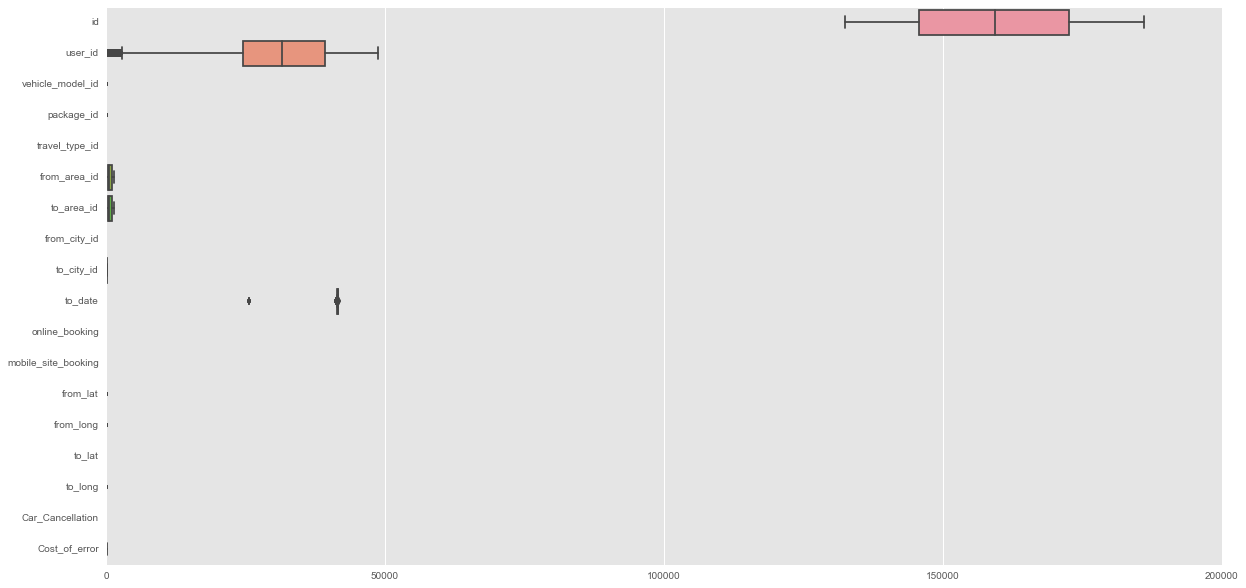

In [90]:
plt.figure(figsize=(20,10))
sns.boxplot(data=df1, orient="h");

# Post Transformation

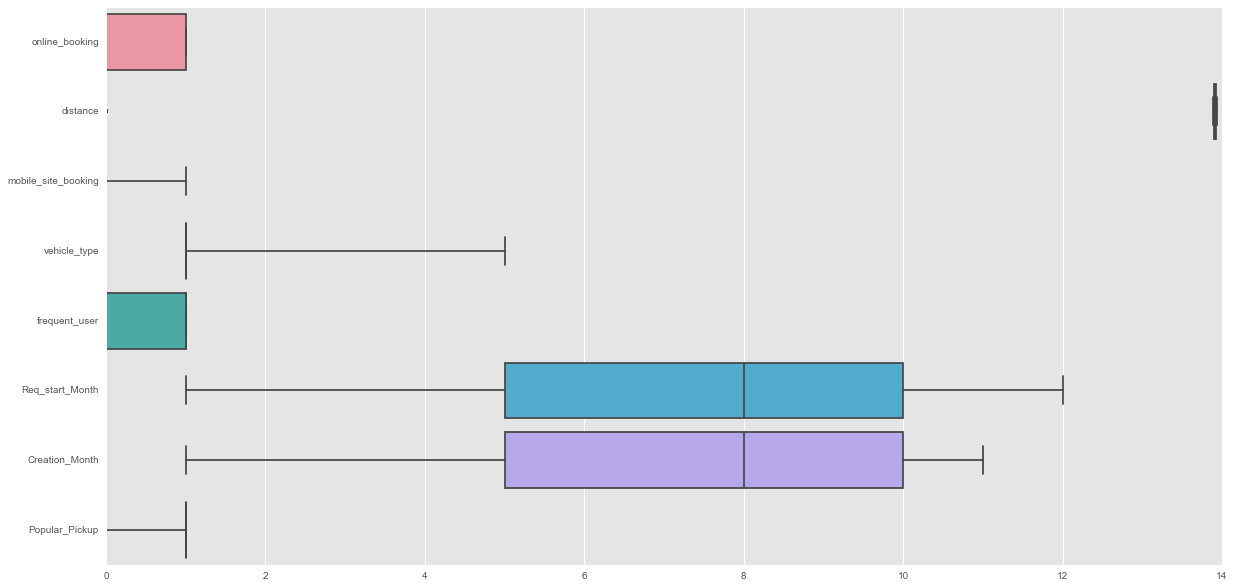

In [91]:
plt.figure(figsize=(20,10))
sns.boxplot(data=X_strat, orient="h");

In [92]:
X_strat.corr()

,online_booking,distance,mobile_site_booking,vehicle_type,frequent_user,Req_start_Month,Creation_Month,Popular_Pickup
online_booking,1.000000,0.065525,-0.251798,-0.017202,-0.173258,0.118390,0.129919,-0.063785
distance,0.065525,1.000000,0.057333,-0.082333,-0.036247,0.024331,0.017310,-0.002011
mobile_site_booking,-0.251798,0.057333,1.000000,-0.020798,-0.018497,0.092565,0.097119,-0.002666
vehicle_type,-0.017202,-0.082333,-0.020798,1.000000,0.000786,-0.028536,-0.029693,0.000473
frequent_user,-0.173258,-0.036247,-0.018497,0.000786,1.000000,0.000408,-0.010096,0.019162
Req_start_Month,0.118390,0.024331,0.092565,-0.028536,0.000408,1.000000,0.995350,0.020960
Creation_Month,0.129919,0.017310,0.097119,-0.029693,-0.010096,0.995350,1.000000,0.014608
Popular_Pickup,-0.063785,-0.002011,-0.002666,0.000473,0.019162,0.020960,0.014608,1.000000


# Sk learn- Logistic regression

In [93]:
#test_X_strat

Here is the breakdown of y 1    2509
0    2502
Name: Car_Cancellation, dtype: int64---
The score --0.7004589902215127
 The no of records in y_hat 5011
Output
1    2592
0    2419
dtype: int64
 The AUC 
The False positive rate is array([ 0.        ,  0.31654676,  1.        ])-
The True positive rate is array([ 0.       ,  0.7174173,  1.       ])-


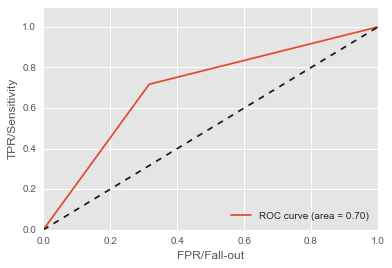

[[ 1.25868874  0.04717875  1.23574616 -0.80927062 -0.53379647  0.73639979
  -0.5742173  -0.29353802]]


In [94]:
model= sk_model(train_X_strat,train_y_strat)
print model.coef_

#model.fit(validation_X_strat , validation_y_strat)
#cross_validation.cross_val_score(estimator, X, y=None, scoring=None, cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')

#plt.figure()
#plt.xlim((1, 10))
#plt.ylim((50, 100))
#plt.scatter(cv_score.index, cv_score, marker = 'x')
#plt.plot(cv_score.index, cv_score)


In [95]:
cv_score = cross_validation.cross_val_score(model ,X = train_X_strat ,y = train_y_strat, cv = 10)
cv_df = pd.DataFrame({'Score':cv_score , 'Iteration':range(1,11)})


In [96]:
cv_df.Score.mean()

0.6986673760049622

## Plotting CV score

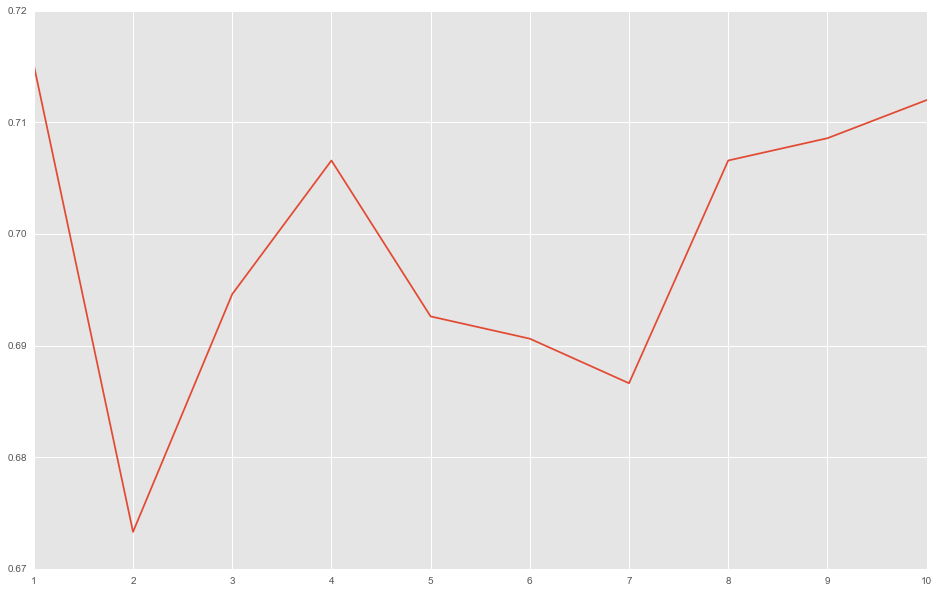

In [97]:
plt.figure(figsize=(16,10))
plt.plot(cv_df.Iteration, cv_df.Score)

### Test set score on Logistic regression

In [98]:
#plt.figure(figsize=(20,10))
model.score(test_X_strat,test_y_strat)

0.6983240223463687

# Decision Tree

In [99]:
model_tree = tree.DecisionTreeRegressor()

#model_tree.fit(X_strat, y_strat_class)
model_tree.fit(train_X_strat, train_y_strat)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [100]:
#model_tree.score(X_strat, y_strat_class)
model_tree.score(train_X_strat, train_y_strat)

0.90466266188080147

## CV on Decision Tree

In [101]:
cross_validation.cross_val_score(model_tree ,X = train_X_strat ,y = train_y_strat,scoring='roc_auc' ,cv = 10)

array([ 0.72209963,  0.68885683,  0.69797425,  0.72542292,  0.70849802,
        0.7104692 ,  0.70438591,  0.71000638,  0.71727177,  0.68199011])

In [102]:
cv_tree_score = cross_validation.cross_val_score(model_tree ,X = train_X_strat ,y = train_y_strat,scoring='roc_auc' ,cv = 10)
cv_tree_df = pd.DataFrame({'Score':cv_tree_score , 'Iteration':range(1,11)})

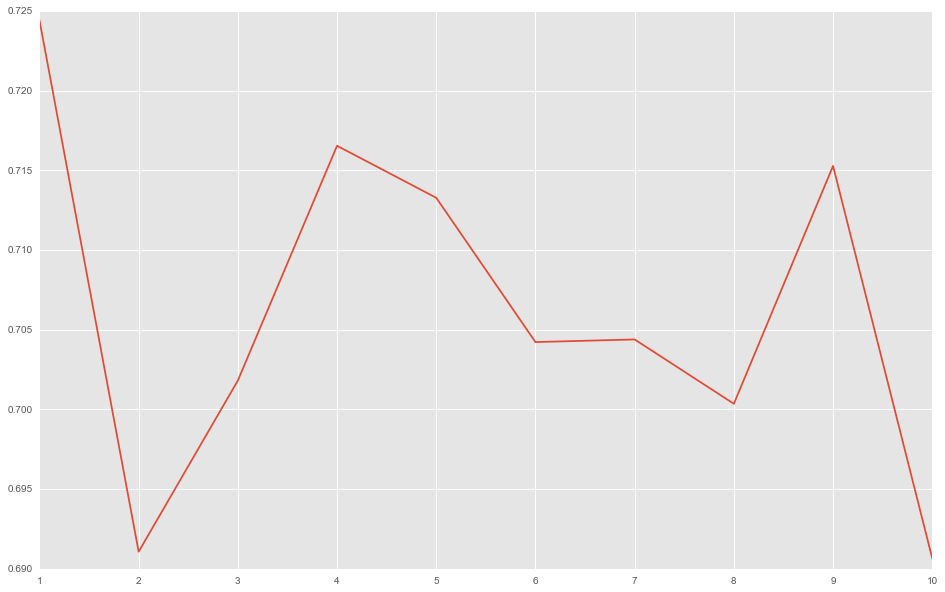

In [103]:
plt.figure(figsize=(16,10))
plt.plot(cv_tree_df.Iteration, cv_tree_df.Score)

In [104]:
cv_tree_df.Score.mean()

0.7061989029441643

In [105]:
model_tree.score(test_X_strat , test_y_strat)

-0.17031503377838297

In [106]:
model_tree.score(test_X_strat , test_y_strat)

-0.17031503377838297

In [107]:
  %reload_ext gvmagic

dot_data = externals.six.StringIO()
tree.export_graphviz(model_tree, out_file = dot_data, feature_names = X_strat.columns)
%dotstr dot_data.getvalue()

# Forest

In [108]:
model_forest = ensemble.RandomForestClassifier( oob_score = True)
model_forest.fit(train_X_strat, train_y_strat)


/Users/dkhandelwal/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [109]:
model_forest.score(train_X_strat, train_y_strat)

0.93813610057872676

In [110]:
cv_forest_score = cross_validation.cross_val_score(model_forest ,X = train_X_strat ,y = train_y_strat,scoring='roc_auc' ,cv = 10)


In [111]:
cv_forest_df = pd.DataFrame({'Score':cv_forest_score , 'Iteration':range(1,11)})

### Note that 96% if the varaiation can be predicted by these 5 features that are listed below

In [113]:
sorted(zip(model_forest.feature_importances_, train_X_strat.columns.values), reverse = True)

[(0.57702450802868266, 'distance'),
 (0.11157230837086447, 'Creation_Month'),
 (0.10572461549557208, 'Req_start_Month'),
 (0.076176196143345851, 'online_booking'),
 (0.043161445160011788, 'frequent_user'),
 (0.040554990764671291, 'vehicle_type'),
 (0.024837758198112878, 'Popular_Pickup'),
 (0.020948177838738823, 'mobile_site_booking')]

## Plotting the CV results for the 10 folds 

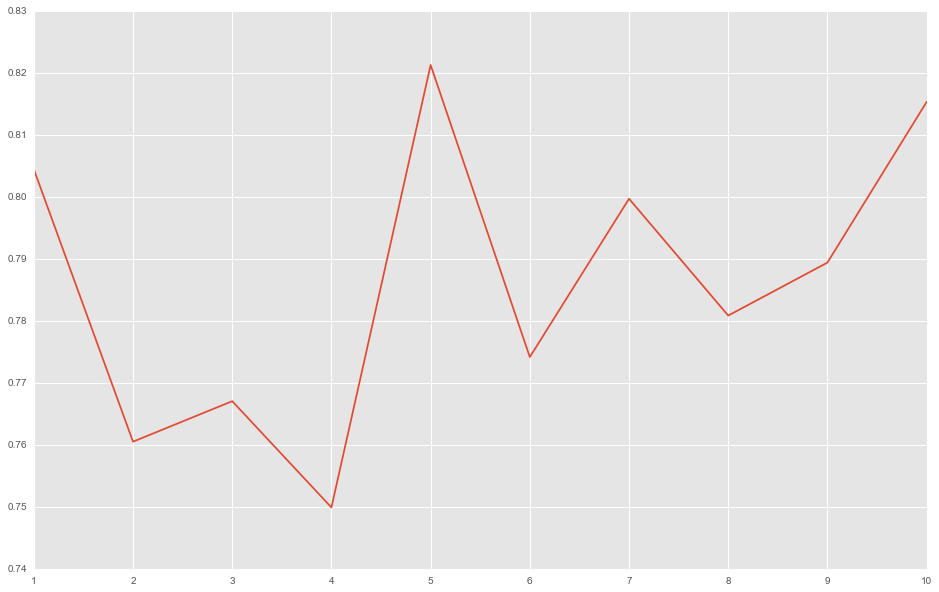

In [114]:
plt.figure(figsize=(16,10))

plt.plot(cv_forest_df.Iteration, cv_forest_df.Score)

In [115]:
model_forest.score(test_X_strat, test_y_strat)

0.7142857142857143

In [116]:

model_forest.oob_score_

0.71183396527639198

# Plots

In [ ]:
#train_df[['distance','Car_Cancellation']]

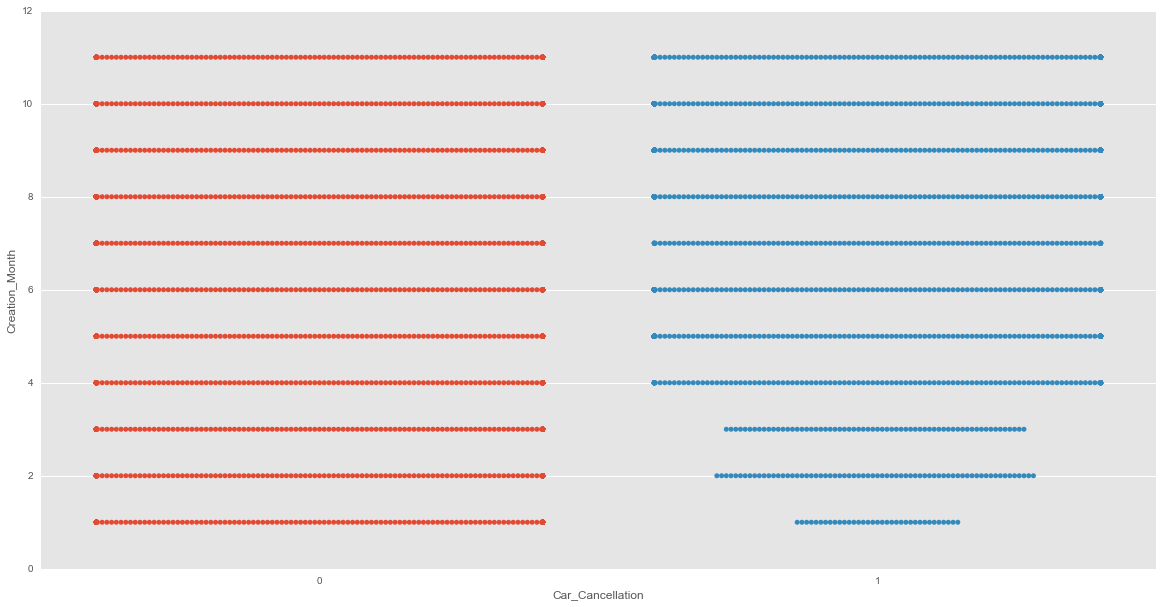

In [122]:
plt.figure(figsize=(20,10))

train_df = X_strat.join(y_strat)
#sns.stripplot(x="Car_Cancellation", y="distance", data=train_df, jitter=True);
sns.swarmplot(x="Car_Cancellation", y="Creation_Month", data=train_df )

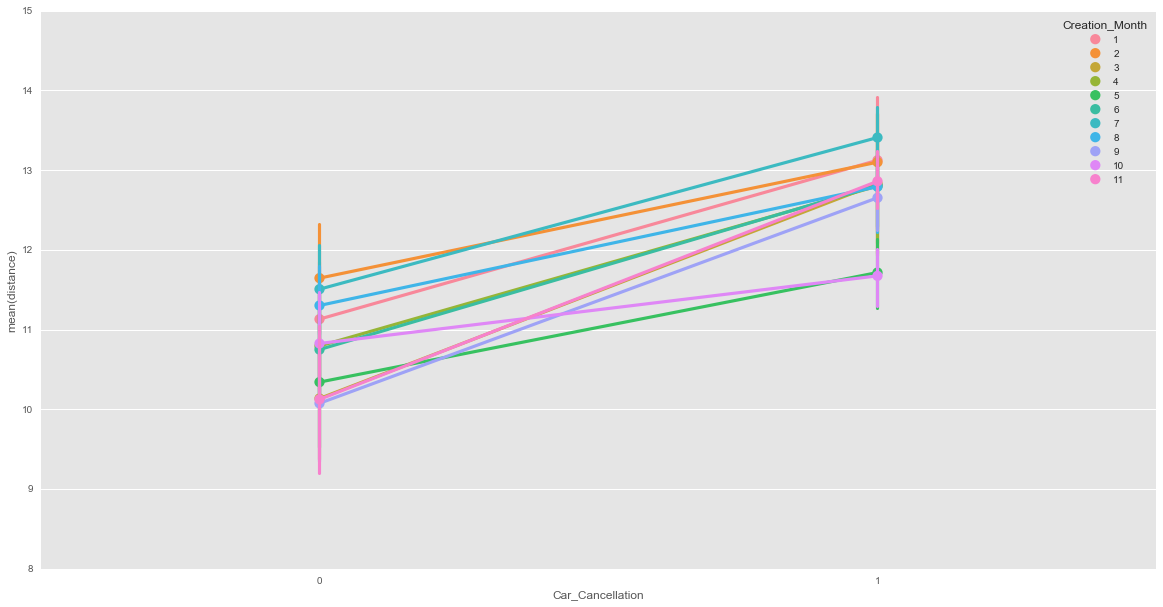

In [118]:
plt.figure(figsize=(20,10))

sns.pointplot(x="Car_Cancellation", y="distance", hue="Creation_Month", data=train_df ,size = 16);

# Interpretation 

## Appears that the chances for the cancellation is maximum in Oct when the mean travel distance is between 12 and 13

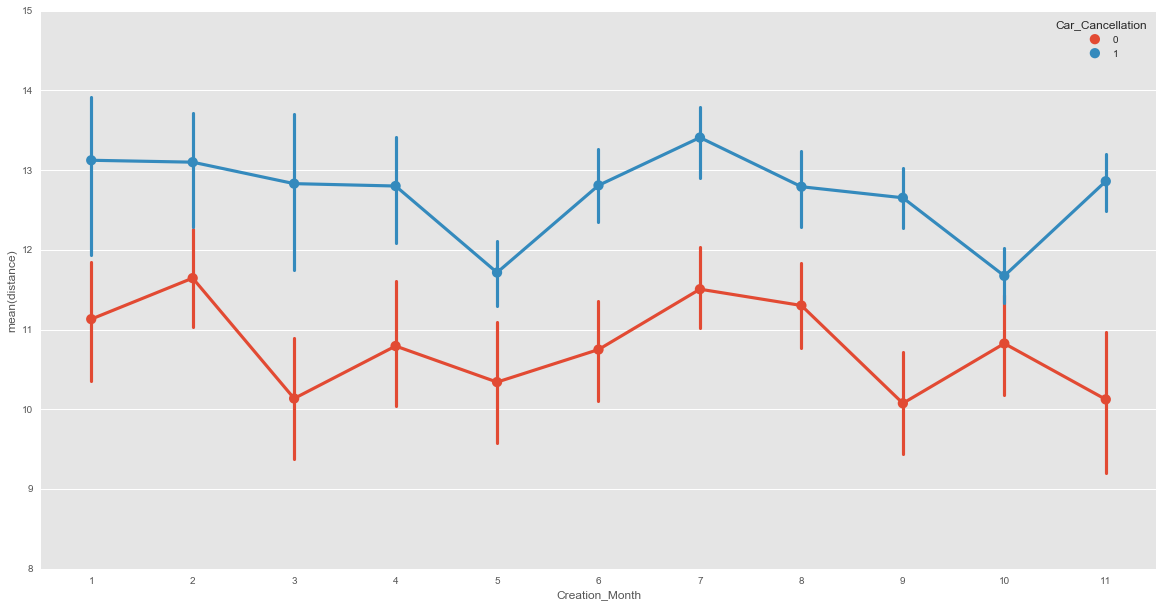

In [124]:
plt.figure(figsize=(20,10))

sns.pointplot(y="distance", x="Creation_Month", hue="Car_Cancellation", data=train_df );